https://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf

In [ ]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes.datasets import load_cdnow_summary, load_cdnow_summary_data_with_monetary_value
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions, plot_calibration_purchases_vs_holdout_purchases, plot_history_alive
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes import GammaGammaFitter

# Customer lifetime value (CLV)

<b>Customer LTV</b> is the metric to understand the net profit attributed to the future relationship between the company and the client. The more the user consumes the product and the longer they continue to use it, the higher the LTV.

Example use case of LTV insight: Take some action towards a customer when her probability of being active reaches a certain threshold to prevent churn


# Beta geometric/negative binomial distribution model

The BD/NGD model is used to calculate the <b>expected number of transactions</b>. We are using <b>recency</b>, <b>tenure</b>, and <b>frequency</b> to calculate this component of CLV


BG/NBD model properties:
<ul>
<li>When a user is active, the number of transactions in a time period of length $t$ is described by Poisson distribution with transaction rate $\lambda$</li>
<li>Heterogeneity in transaction rate across users (meaning how customers differ in purchasing behavior) has Gamma distribution with parameters $r$ (shape) and $\alpha$ (scale) </li>
<li>Users may become inactive after any transaction with probability $p$ and their dropout point (when they become inactive) is distributed between purchases with Geometric distribution
<li>Heterogeneity (variation across users) in dropout probability has Beta distribution with the two shape parameters $\alpha$ and $\beta$</li>
<li>Transaction rate and dropout probability independently vary across users</li>
</li>
</ul>

The Greeks in the model have the following roles:
<ul>
<li>Poisson distribution helps to predict certain events happening using the data about how often event occurred in past</li>
<li>Gamma distribution arises naturally in processes with waiting time between Poisson distributed events (as in our case for transaction rate $\lambda$)</li>
<li>Geometric distribution is similar to Bernoulli trials and is used for modeling the number of trials up to and including the first success</li>
<li>Beta distribution is the best for representing a probabilistic distribution of probabilities — the case where we don’t know what a probability is in advance, but we have some reasonable priors, described by $\alpha$ and $\beta$ (mean of a Beta distribution $\frac{\alpha}{\alpha + \beta}$)</li>
</ul>

# Gamma - Gamma model

The Gamma - Gamma model is used to calculate the <b>expected average profit</b>. We are using <b>frequency</b> and <b>monetary</b> to calculate this component of CLV.

The model assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

https://www.brucehardie.com/notes/025/gamma_gamma.pdf

# About the data

<ul>
<li>Frequency - the number of repeat purchases the customer has made</li>
<li>Recency - the duration between a customer’s first purchase and their latest purchase</li>
<li>T - the duration between a customer’s first purchase and the end of the period under study</li>
</ul>

In [ ]:
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


## Fit a BG-NGD model

In [ ]:
bgf = BetaGeoFitter(penalizer_coef =0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


## Visualizing frequency recency matrix

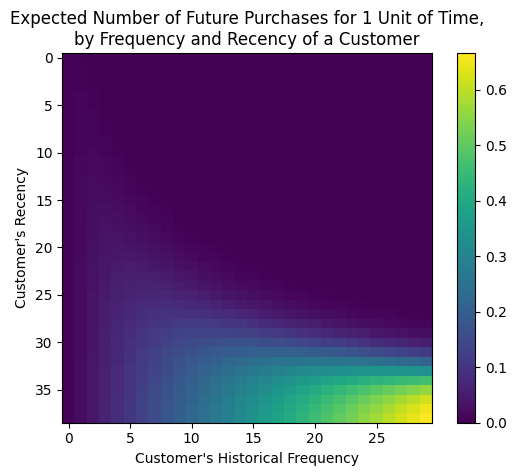

In [ ]:
plot_frequency_recency_matrix(bgf)
plt.show()

## Visualizing frequency recency matrix

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

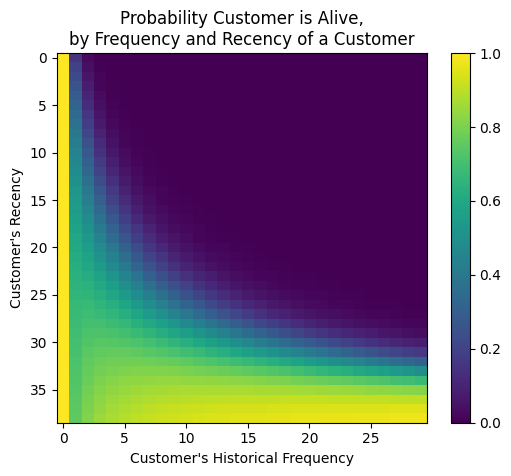

In [ ]:
plot_probability_alive_matrix(bgf)

## Ranking Customers (Best to Worst)

Highest expected purchase in the next period

In [ ]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(10)

,frequency,recency,T,predicted_purchases
ID,,,,
1017,12,32.43,33.43,0.296308
693,13,34.43,35.00,0.312249
813,13,33.86,34.29,0.318802
1413,14,30.29,31.57,0.360929
1539,14,29.86,30.86,0.371088
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662396


## Assessing model fit

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

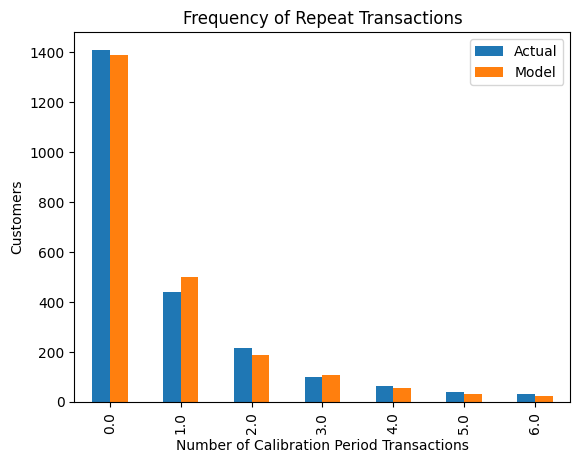

In [ ]:
plot_period_transactions(bgf)

## Model Using Transactional Dataset

In [ ]:
transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [ ]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end = '2014-12-31')
print(summary.head())

    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


In [ ]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

## Model Fitting

In [ ]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date', calibration_period_end = '2014-09-01', observation_period_end = '2014-12-31')
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0             121.0
1             0.0          0.0  103.0                0.0             121.0
2             6.0        142.0  171.0                0.0             121.0
3             0.0          0.0   26.0                0.0             121.0
4             2.0          9.0   62.0                0.0             121.0


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

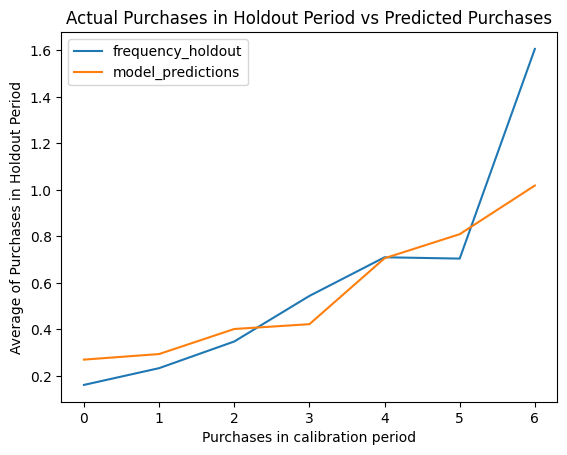

In [ ]:
bgf.fit(summary_cal_holdout['frequency_cal'],summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'] )

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

## Customer Predictions

In [ ]:
t = 10 #to predict purchases in 10 periods
individual = summary.iloc[20]

#the below 'predict' function is an alias to 'bgf.conditional_expected_number_of_purchases_up_to_time'
bgf.predict(t, individual['frequency'],individual['recency'], individual['T'])

0.057651165918270415

# Gamma-Gamma model

In [ ]:
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()

returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency'] > 0]
print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


## Independence Assumption

In [ ]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


# Train the Gamma-Gamma model

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],returning_customers_summary['monetary_value'])

print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


## Estimate the Average Transaction Value

In [ ]:
print(ggf.conditional_expected_average_profit(
    summary_with_money_value['frequency'],summary_with_money_value['monetary_value']).head())

customer_id
1    24.658616
2    18.911480
3    35.171002
4    35.171002
5    35.171002
dtype: float64


In [ ]:
print(print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
)))

Expected conditional average profit: 35.25295817604993, Average profit: 35.07855179704017
None


# Compute the Total CLV using Discounted Cash Flow Method

In [ ]:
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01
).head(10))

customer_id
1      140.096218
2       18.943466
3       38.180575
4       38.180575
5       38.180575
6     1003.868285
7       28.109681
8       38.180575
9      167.418224
10      38.180575
Name: clv, dtype: float64
